# HUYNH Ngoc Thai Duy (Valdom)

Complete the following box to setup your configuration

In [ ]:
from docplex.cp.model import *
context.solver.agent = 'local'
#context.solver.local.execfile = 'Path to the binary cpoptimizer' --> At INSA we use the following:
context.solver.local.execfile = '/usr/local/insa/ibm_cplex_studio_2211/cpoptimizer/bin/x86-64_linux/cpoptimizer'
context.verbose = 0



#The solver's documentation is here
#https://ibmdecisionoptimization.github.io/docplex-doc/cp/index.html

/home/nhuynh/.local/lib/python3.11/site-packages/docplex/cp/__init__.py:62: RuntimeWarning: docplex.cp is supported by Python versions 2.7.9+, 3.4.x, to 3.10.x, not '3.11.3.final.0'. Use it at your own risk.
  warnings.warn(msg, RuntimeWarning)


Please use the following parameters each time you call the solver

In [ ]:
myparams = CpoParameters(TimeLimit= 20,
                            LogVerbosity="Quiet" ,
                             SearchType = 'DepthFirst',
                             Presolve = 'Off',
                             Workers=  1,
                             RandomSeed = 2)

You can add as many cells as you want. Make sure to choose "Markdown" instead of "code" if you want to write in a natural language.

When submitting your work, please re-execute the notebook from the start and do not remove the output.

We want to set up a speed interview event between $n$ students and $n$ companies. Each student has a unique list that reflects his preferences towards companies. The first element is the most prefered company, the second one is the second most prefered, etc. For instance, if Alice's list of preferences is [4,1,3,2]. Then she prefers to be assigned to  company 4, then 1, then 3, then 2. Similarly, each company has a list of preferences towards students. The preferences represent a strict order (i.e., no ties).

A matching $M$ is a one-to-one mapping from students to companies. Let $s$ be a student and $c$ be a company. The pair $(s,c)$ is unhappy in $M$ if they prefer to be together compared to their situation in $M$. That is, if $M[s] =c' $ and $ s' = M^{-1}[c]$ then $s$ prefers c than $c'$, and $c$ prefers $s$ than $s'$.


The stable interview problem is the problem of finding a matching that has no unhappy pair.

# Example

The following code generates a random list of preferences

In [ ]:
import numpy as np
import random

#Run The model
# Example data
def generate_random_list(n) :
    my_list = [i for i in range (n)]
    return random.sample(my_list, len(my_list))

To generate a random instance of the speed interview problem, we use the following function

In [ ]:
#Gererate an instance of size $6$
def generate_random_instance(n) :

    s = [generate_random_list(n) for i in range(n)]
    c = [generate_random_list(n) for i in range(n)]
    return s, c


Generate a random instance of size 4

In [ ]:
#Example with n= 6
n=4
students_preferences, companies_preferences = generate_random_instance(n)

print("\nstudents_preferences:")
print(np.matrix(students_preferences))

print("\ncompanies_preferences Preferences:")
print(np.matrix(companies_preferences))



students_preferences:
[[1 2 0 3]
 [3 2 0 1]
 [3 0 1 2]
 [3 0 2 1]]

companies_preferences Preferences:
[[2 3 0 1]
 [0 1 3 2]
 [2 3 1 0]
 [1 2 3 0]]




Complete the following function to model the stable interview problem. Do not call the solver to search for solutions in this function. We will do it saperately later.


You can use the element expression if you want (but it is not mandatory) :  https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html?highlight=element#docplex.cp.modeler.element

Firstly, we describe the CP model for SM for finding a complete matching. The model uses a variable $m_i$ for each student $x_i \in S$, and $w_j$ for each company $y_j \in C$. For each variable $m_i$,

$$\text{domain}(m_i) = \{j : y_j \text{ is acceptable to } x_i\}.$$

For each $w_j$, $\text{domain}(w_j)$ is defined similarly.

For every pair $(x_i, y_j)$ of a student $x_i \in S$ and a company $y_j \in C$ that are acceptable to each other, the CP model includes the following constraints:

- $\neg(w_j = i' \land m_i = j)$ $(x_{i'} \in S, i \neq i', x_{i'} \text{ is acceptable to } y_j)$,
- $\neg(m_i = j' \land w_j = i)$ $(y_{j'} \in C, j \neq j', y_{j'} \text{ is acceptable to } x_i)$,
- $\neg(w_j = i' \land m_i = j')$ $(x_{i'} \in S, y_{j'} \in C, \text{mrank}(x_i, y_j) < \text{mrank}(x_i, y_{j'}), \text{wrank}(y_j, x_i) < \text{wrank}(y_j, x_{i'}))$.

The first constraint above guarantees that a company $y$ is matched to exactly one student. The second constraint guarantees that a student $x$ is matched to exactly one company. The third constraint guarantees that there is no pair $(x, y) \in S \times C$ such that $x$ is matched to a company $y'$ and $y$ is matched to a student $x'$ where $x$ and $y$ prefer each other to their current partners. In this way, the CP model ensures that there are no blocking pairs, hence the stability of the matching.

[Reference](https://research.sabanciuniv.edu/id/eprint/47475/1/10491715.pdf)

SOLVING HARD STABLE MARRIAGE PROBLEMS USING LOGIC-BASED METHODS

SELİN EYÜPOĞLU

Computer Science and Engineering M.Sc. Thesis, July 2022

Thesis Supervisor: Prof. Dr. Esra Erd


In [ ]:
def stable_interview (n, students_preferences, companies_preferences):
    model = CpoModel(name='Student-Company Matching Problem')

    # Variables: Matching of students to companies and vice versa
    match_students = [model.integer_var(min=0, max=n-1, name=f"match_students_{i}") for i in range(n)]
    match_companies = [model.integer_var(min=0, max=n-1, name=f"match_companies_{j}") for j in range(n)]

    # Ensuring mutual matching
    for i in range(n):
        for j in range(n):
            model.add(model.if_then(match_students[i] == j, match_companies[j] == i))
    # Stable condition
    for s1 in range(n):  # For each student
        for c1 in range(n):  # For each company
            for s2 in range(n):  # Compare with every other student
                for c2 in range(n):  # And every other company
                    if s1 != s2 and c1 != c2:
                        pref_s1_c2 = students_preferences[s1].index(c2)  # s1's preference rank for c2
                        pref_s1_c1 = students_preferences[s1].index(c1)  # s1's preference rank for c1
                        pref_c2_s1 = companies_preferences[c2].index(s1)  # c2's preference rank for s1
                        pref_c2_s2 = companies_preferences[c2].index(s2)  # c2's preference rank for s2
                        condition = model.logical_and(pref_s1_c2 < pref_s1_c1, pref_c2_s1 < pref_c2_s2)

                        model.add(model.if_then(condition,
                                                model.logical_not(model.logical_and(match_students[s1] == c1,
                                                                                    match_students[s2] == c2))))

    return model

Test your function on an instance of size n= 10. Ask the solver to generate only one solution

In [ ]:
students_preferences, companies_preferences = generate_random_instance(10)
model = stable_interview (5, students_preferences, companies_preferences)
all_expressions = model.get_all_expressions()
for expr, loc in all_expressions:
    print("Expression:", expr)


Expression: (match_students_0 == 0) => (match_companies_0 == 0)
Expression: (match_students_0 == 1) => (match_companies_1 == 0)
Expression: (match_students_0 == 2) => (match_companies_2 == 0)
Expression: (match_students_0 == 3) => (match_companies_3 == 0)
Expression: (match_students_0 == 4) => (match_companies_4 == 0)
Expression: (match_students_1 == 0) => (match_companies_0 == 1)
Expression: (match_students_1 == 1) => (match_companies_1 == 1)
Expression: (match_students_1 == 2) => (match_companies_2 == 1)
Expression: (match_students_1 == 3) => (match_companies_3 == 1)
Expression: (match_students_1 == 4) => (match_companies_4 == 1)
Expression: (match_students_2 == 0) => (match_companies_0 == 2)
Expression: (match_students_2 == 1) => (match_companies_1 == 2)
Expression: (match_students_2 == 2) => (match_companies_2 == 2)
Expression: (match_students_2 == 3) => (match_companies_3 == 2)
Expression: (match_students_2 == 4) => (match_companies_4 == 2)
Expression: (match_students_3 == 0) => (

In [ ]:
# Solve the model
n=20
myparams = CpoParameters(TimeLimit=20,
                         LogVerbosity="Quiet",
                         SearchType='DepthFirst',
                         Presolve='Off',
                         Workers=1,
                         RandomSeed=2,
                         SolutionLimit=1)  # Set the solver to stop after finding the first solution____________
students_preferences, companies_preferences = generate_random_instance(n)
model = stable_interview (n, students_preferences, companies_preferences)
solution = model.solve(params=myparams)
print("Solution found:")
for i in range(n):
    matched_company = solution.get_value("match_students_{}".format(i))
    print(f"Student {i} is matched with Company {matched_company}")


Solution found:
Student 0 is matched with Company 10
Student 1 is matched with Company 4
Student 2 is matched with Company 18
Student 3 is matched with Company 8
Student 4 is matched with Company 9
Student 5 is matched with Company 12
Student 6 is matched with Company 2
Student 7 is matched with Company 17
Student 8 is matched with Company 5
Student 9 is matched with Company 19
Student 10 is matched with Company 1
Student 11 is matched with Company 6
Student 12 is matched with Company 14
Student 13 is matched with Company 15
Student 14 is matched with Company 0
Student 15 is matched with Company 11
Student 16 is matched with Company 13
Student 17 is matched with Company 16
Student 18 is matched with Company 7
Student 19 is matched with Company 3


How many decisions are made ?

In [ ]:
solution.get_solver_infos()['NumberOfBranches']

1080

How many failures are made ?

In [ ]:
solution.get_solver_infos()['NumberOfFails']

536

What is the runtime ?

In [ ]:
solution.get_solver_infos()['TotalTime']

1.83

# Without changing your model, did you use an implied constraint? if yes, which one ? If no, can you find one (again without modifying the model) ?
The implies constraint in this problem is  that the matching much has no unhappy pair.

We want to setup a user-friendly solution printer. Let $CompanyOf[s]$ be the company to which student $s$ is matched. Similarly, we denote by $StudentOf[c]$ the student assigned to company $c$.


Solve again the problem for n= 10, construct the lists $CompanyOf$ and  $StudentOf$, then print them.

In [ ]:
n=15
students_preferences, companies_preferences = generate_random_instance(n)
model = stable_interview (n, students_preferences, companies_preferences)
solution = model.solve(params=myparams)
if solution:
    print("Solution found:")
    for i in range(n):
        matched_company = solution.get_value("match_students_{}".format(i))
        print(f"Student {i} is matched with Company {matched_company}")
else:
    print('Soluiton not found')

Solution found:
Student 0 is matched with Company 9
Student 1 is matched with Company 5
Student 2 is matched with Company 11
Student 3 is matched with Company 14
Student 4 is matched with Company 13
Student 5 is matched with Company 7
Student 6 is matched with Company 1
Student 7 is matched with Company 12
Student 8 is matched with Company 0
Student 9 is matched with Company 4
Student 10 is matched with Company 6
Student 11 is matched with Company 8
Student 12 is matched with Company 3
Student 13 is matched with Company 2
Student 14 is matched with Company 10


We want to automate the experiments. Complete the following function that takes as input n, generates a new random instance, solve it, then returns the search status, the number of decisions, the number of failures, and the runtime

In [ ]:
from docplex.cp.model import  CpoParameters
def run_decision_version(n) :
    students_preferences, companies_preferences = generate_random_instance(n)
    model = stable_interview (n, students_preferences, companies_preferences)
    #context.solver.trace_log = False
    solution = model.solve(params=myparams)
    status = solution
    nb_decisions = solution.get_solver_infos()['NumberOfBranches']
    nb_failures = solution.get_solver_infos()['NumberOfFails']
    runtime =solution.get_solver_infos()['TotalTime']

    return status, nb_decisions, nb_failures, runtime

Test your function with a random instance. Print the status, the number of decisions, the number of failures, and the runtime

In [ ]:
status, nb_decisions, nb_failures, runtime = run_decision_version(30)
if status :
    print("Status: Solution found")
    print(f"Number of dicisions = {nb_decisions}")
    print(f"Number of failures = {nb_failures}")
    print(f"Run times = {runtime}")
else:
    print("No solution found")


Status: Solution found
Number of dicisions = 4167
Number of failures = 2075
Run times = 17.83


Test the run function with four different sizes


In [ ]:
sizes = [5,10,15,20]
for size in sizes:
    status, nb_decisions, nb_failures, runtime = run_decision_version(size)
    if status :
        print("Status: Solution found")
        print(f"Number of dicisions = {nb_decisions}")
        print(f"Number of failures = {nb_failures}")
        print(f"Run times = {runtime}")
        print("______________________________________________________")
    else:
        print("No solution found")


Status: Solution found
Number of dicisions = 7
Number of failures = 2
Run times = 0.01
______________________________________________________
Status: Solution found
Number of dicisions = 71
Number of failures = 34
Run times = 0.07
______________________________________________________
Status: Solution found
Number of dicisions = 253
Number of failures = 122
Run times = 0.42
______________________________________________________
Status: Solution found
Number of dicisions = 1635
Number of failures = 811
Run times = 2
______________________________________________________


Find 10 different numbers $n_1 > n_2, \ldots > n_{10}$ such that the solver needs between $10$s to $20$s to find a solution for each size

Choose two completely different search strategies, then run them on a random instance

In [ ]:
n = 15
found_sizes = []
while len(found_sizes) < 10:
    status, nb_decisions, nb_failures, runtime = run_decision_version(n)
    print(f"Problem size = {n}, Run time = {runtime}s")
    if 10 <= runtime <= 20:
        #print(f"Problem size = {n}, Run time = {runtime}s")
        found_sizes.append(n)

    n += 1


    if runtime > 20:
        print(f"Run time = {runtime}")
        break

print("Found problem sizes:", found_sizes)


Problem size = 15, Run time = 0.44s
Problem size = 16, Run time = 0.57s
Problem size = 17, Run time = 0.77s
Problem size = 18, Run time = 0.91s
Problem size = 19, Run time = 1.22s
Problem size = 20, Run time = 1.5s
Problem size = 21, Run time = 1.72s
Problem size = 22, Run time = 2.55s
Problem size = 23, Run time = 2.72s
Problem size = 24, Run time = 9.64s
Problem size = 25, Run time = 15.59s
Problem size = 26, Run time = 20.03s
Run time = 20.03
Found problem sizes: [25]


Run an experimental study to campare the two search strategies in terms of the number of decisions and runtime on 20 instances of different sizes of your choice. We expect to have a visual comparision in the form of plots

In [ ]:

def run_search_strategies(n, search_strategy):

    students_preferences, companies_preferences = generate_random_instance(n)
    model = stable_interview(n, students_preferences, companies_preferences)


    myparams = CpoParameters(TimeLimit=20,
                             LogVerbosity="Quiet",
                             SearchType=search_strategy,
                             Presolve='Off',
                             Workers=1,
                             RandomSeed=2)


    solution = model.solve(params=myparams)


    if solution:
        nb_decisions = solution.get_solver_infos()['NumberOfBranches']
        nb_failures = solution.get_solver_infos()['NumberOfFails']
        runtime = solution.get_solver_infos()['TotalTime']
        return n, nb_decisions, runtime
    else:
        return n, None, None

In [ ]:
problem_sizes = list(range(5, 20))
strategies = ['DepthFirst', 'Neighborhood', 'MultiPoint']
results = []

for strategy in strategies:
    for size in problem_sizes:
        size, decisions, runtime = run_search_strategies(size,strategy)
        results.append((strategy, size, decisions, runtime))

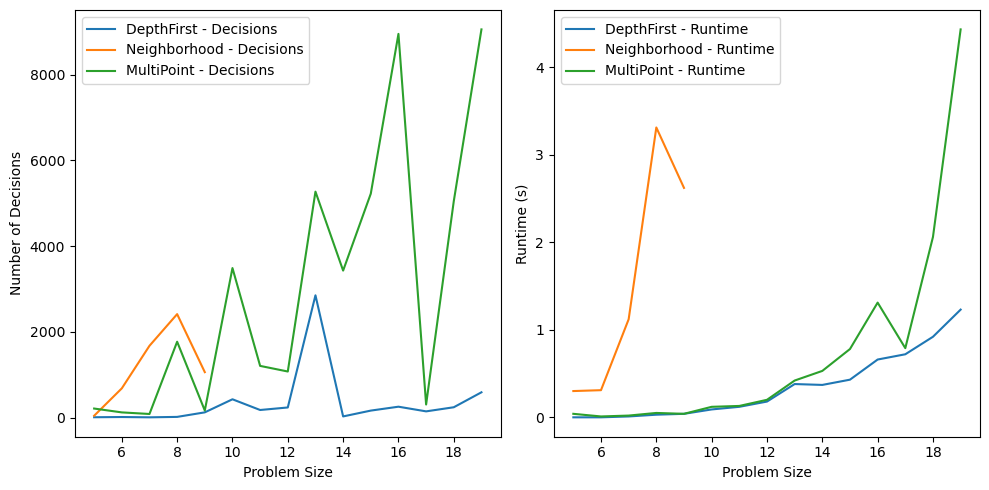

In [ ]:
import matplotlib.pyplot as plt

# Splitting results by strategy
depthfirst_results = [result for result in results if result[0] == 'DepthFirst']
neighborhood_results = [result for result in results if result[0] == 'Neighborhood']
MultiPoint_results = [result for result in results if result[0] == 'MultiPoint']
# Plotting
plt.figure(figsize=(10, 5))

# Number of Decisions
plt.subplot(1, 2, 1)
plt.plot([r[1] for r in depthfirst_results], [r[2] for r in depthfirst_results], label='DepthFirst - Decisions')
plt.plot([r[1] for r in neighborhood_results], [r[2] for r in neighborhood_results], label='Neighborhood - Decisions')
plt.plot([r[1] for r in MultiPoint_results], [r[2] for r in MultiPoint_results], label='MultiPoint - Decisions')
plt.xlabel('Problem Size')
plt.ylabel('Number of Decisions')
plt.legend()

# Runtime
plt.subplot(1, 2, 2)
plt.plot([r[1] for r in depthfirst_results], [r[3] for r in depthfirst_results], label='DepthFirst - Runtime')
plt.plot([r[1] for r in neighborhood_results], [r[3] for r in neighborhood_results], label='Neighborhood - Runtime')
plt.plot([r[1] for r in MultiPoint_results], [r[3] for r in MultiPoint_results], label='MultiPoint - Runtime')
plt.xlabel('Problem Size')
plt.ylabel('Runtime (s)')
plt.legend()

plt.tight_layout()
plt.show()

We want to give more previlage to students. Let $M$ be a solution and let $Index[s]$ be the index of $M[s]$ in the preference list of $s$. We want to minimize the maximum value of $\{Index[1], \ldots Index[N] \}$. Complete the following function to model for this optimisation problem.

In [ ]:
def optimal_stable_interview (n, students_preferences, companies_preferences):
    model = CpoModel(name='Student-Company Matching Problem')

    # Variables: Matching of students to companies and vice versa
    match_students = [model.integer_var(min=0, max=n-1, name=f"match_students_{i}") for i in range(n)]
    match_companies = [model.integer_var(min=0, max=n-1, name=f"match_companies_{j}") for j in range(n)]
    max_index = model.integer_var(min=0, max=n-1, name="max_index")
    # Ensuring mutual matching
    for i in range(n):
        for j in range(n):
            model.add(model.if_then(match_students[i] == j, match_companies[j] == i))
    # Stable condition
    for s1 in range(n):  # For each student
        for c1 in range(n):  # For each company
            for s2 in range(n):  # Compare with every other student
                for c2 in range(n):  # And every other company
                    if s1 != s2 and c1 != c2:
                        pref_s1_c2 = students_preferences[s1].index(c2)  # s1's preference rank for c2
                        pref_s1_c1 = students_preferences[s1].index(c1)  # s1's preference rank for c1
                        pref_c2_s1 = companies_preferences[c2].index(s1)  # c2's preference rank for s1
                        pref_c2_s2 = companies_preferences[c2].index(s2)  # c2's preference rank for s2
                        condition = model.logical_and(pref_s1_c2 < pref_s1_c1, pref_c2_s1 < pref_c2_s2)

                        model.add(model.if_then(condition,
                                                model.logical_not(model.logical_and(match_students[s1] == c1,
                                                                                    match_students[s2] == c2))))
    for s in range(n):
        model.add(max_index >= model.element(students_preferences[s], match_students[s]))

    # Set the objective to minimize max_index
    model.minimize(max_index)
    return model

Test your model

In [ ]:
n=15
students_preferences, companies_preferences = generate_random_instance(n)
model = optimal_stable_interview (n, students_preferences, companies_preferences)

solution = model.solve(params=myparams)
if solution :
        print("Status: Solution found")
        print(f"Number of dicisions = {nb_decisions}")
        print(f"Number of failures = {nb_failures}")
        print(f"Run times = {runtime}")
        for i in range(n):
            matched_company = solution.get_value("match_students_{}".format(i))
            print(f"Student {i} is matched with Company {matched_company}")
            optimal = solution.get_value("max_index")
        print(f"Minimun of max index {optimal}")
        print("______________________________________________________")
else:
        print("No solution found")



Status: Solution found
Number of dicisions = 9502
Number of failures = 4748
Run times = 4.43
Student 0 is matched with Company 11
Student 1 is matched with Company 14
Student 2 is matched with Company 9
Student 3 is matched with Company 5
Student 4 is matched with Company 1
Student 5 is matched with Company 7
Student 6 is matched with Company 0
Student 7 is matched with Company 6
Student 8 is matched with Company 3
Student 9 is matched with Company 13
Student 10 is matched with Company 12
Student 11 is matched with Company 2
Student 12 is matched with Company 10
Student 13 is matched with Company 8
Student 14 is matched with Company 4
Minimun of max index 11
______________________________________________________
